# <center> Demo Inference </center>

In [1]:
import random
from functools import partial
from omegaconf import DictConfig
import os
import torch
import rasterio
import numpy as np
from pathlib import Path
import h5py
from typing import Dict, Any
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)   # ou FutureWarning, UserWarning, ...

import argparse
import json
import os
import pprint
import sys
from pathlib import Path
import torch
from omegaconf import OmegaConf
from torch.utils.tensorboard import SummaryWriter

from data.uncrtaints_adapter import UnCRtainTS_CIRCA_Adapter
from dataloader_CIRCA_old.datasets.CIRCA_dataset_for_UnCRtainTS import CircaPatchDataSetForUnCRtainTS
from torch.utils.tensorboard import SummaryWriter
os.chdir(os.path.join(os.getcwd(), "model"))

from parse_args import create_parser
from src.model_utils import get_model, load_checkpoint
from src import utils
from train_reconstruct import (
    iterate,
    prepare_output,
    save_results,
    seed_packages,
)
from model.imputation import iterate_one_sample
if os.getcwd().endswith("model"):
    os.chdir(os.path.dirname(os.getcwd()))

In [2]:
def prepare_output(config):
    os.makedirs(os.path.join(config.res_dir, config.experiment_name), exist_ok=True)

In [3]:
# Définition des chemins pour faire l'inférence
from pathlib import Path
from model.src.config_utils import read_config
from omegaconf import OmegaConf

demo_config = Path("./configs/test_CIRCA.yaml")
assert demo_config.exists()
params_conf_file = read_config(demo_config)
parser = create_parser(mode="test")
test_config, _ = parser.parse_known_args()
test_config.pid = os.getpid()                                                                                                                                                                                                                                                                                                                                                                                 
test_config = OmegaConf.create(vars(test_config))
assert test_config.get("sample_type", False)

# Récupération des paramètres issus du modèle 
NO_OVERWRITE = ['pid', 'device', 'resume_at', 'trained_checkp', 'res_dir', 'weight_folder', 'root1', 'root2', 'root3', 'max_samples_count', 'batch_size', 'display_step', 'plot_every', 'export_every', 'input_t', 'region', 'min_cov', 'max_cov']
conf_path = os.path.join(params_conf_file.weight_folder, params_conf_file.experiment_name, "conf.json")
model_config = OmegaConf.create(json.load(open(conf_path)))
for key_to_delete in NO_OVERWRITE:
    if model_config.get(key_to_delete, False):
        model_config.pop(key_to_delete)
# Mise à jour des paramètres de base du parser par les paramètres pris pour la création du modèle utilisé pour l'inférence 
test_config.update(model_config)
test_config.__dict__.update(params_conf_file)
test_config = utils.str2list(test_config, ["encoder_widths", "decoder_widths", "out_conv"])
config = test_config

In [4]:
S1_LAUNCH: str = "2014-04-03"
SEN12MSCRTS_SEQ_LENGTH: int = 30  # Length of the Sentinel time series
CLEAR_THRESHOLD: float = 1e-3  # Threshold for considering a scene as cloud-free

device = torch.device(config.device)
prepare_output(config)

model = get_model(config)
model = model.to(device)
config.N_params = utils.get_ntrainparams(model)
print(f"TOTAL TRAINABLE PARAMETERS: {config.N_params}\n")

circa_ds = UnCRtainTS_CIRCA_Adapter(
    phase="test",
    hdf5_file=config.hdf5_file,
    shuffle=config.shuffle,
    use_sar=config.use_sar,
    channels=config.channels,
    compute_cloud_mask=False,
    # paramaters specific to UnCRtainTS
    cloud_masks= "s2cloudless_mask",
    sample_type=config.sample_type,
    sampler=config.sampler,
    n_input_samples=config.input_t ,
    rescale_method= "default",
    min_cov= 0.0,
    max_cov= 1.0,
    ref_date= S1_LAUNCH,
    clear_threshold=CLEAR_THRESHOLD,
    vary_samples=False, 
)

dt_test = torch.utils.data.Subset(
    circa_ds, range(0, min(config.max_samples_count, len(circa_ds)))
)

test_loader = torch.utils.data.DataLoader(
    dt_test, 
    batch_size=config.batch_size,
    shuffle=config.shuffle,
    num_workers=config.num_workers,
    #collate_fn=circa_collate_fn  # Utiliser notre fonction personnalisée
)

TOTAL TRAINABLE PARAMETERS: 635412



In [5]:
chckp_path = os.path.join(config.weight_folder, config.experiment_name, f"model.pth.tar")
print(f"Loading checkpoint {chckp_path}")
checkpoint = torch.load(chckp_path, map_location=config.device)["state_dict"]

try:  # try loading checkpoint strictly, all weights & their names must match
    model.load_state_dict(checkpoint, strict=True)
    print("Loaded checkpoint with matching keys")
except:
    # rename keys
    #   in_block1 -> in_block0, out_block1 -> out_block0
    checkpoint_renamed = dict()
    for key, val in checkpoint.items():
        if "in_block" in key or "out_block" in key:
            strs = key.split(".")
            strs[1] = strs[1][:-1] + str(int(strs[1][-1]) - 1)
            strs[1] = ".".join([strs[1][:-1], strs[1][-1]])
            key = ".".join(strs)
        checkpoint_renamed[key] = val
    model.load_state_dict(checkpoint_renamed, strict=False)

# Inference
print("Testing . . .")
_ = model.eval()

Loading checkpoint /DATA_10TB/data_rpg/outputs/UnCRtainTS/results/train/UnCRtainTS_bs_7_MGNLL_experiment/model.pth.tar
Loaded checkpoint with matching keys
Testing . . .


In [6]:
def sample_to_batch(sample: dict) -> dict:
    batch = {}
    for k, v in sample.items():
        if isinstance(v, torch.Tensor):
            batch[k] = v.unsqueeze(dim=0)
        else:
            batch[k] = v
    return batch

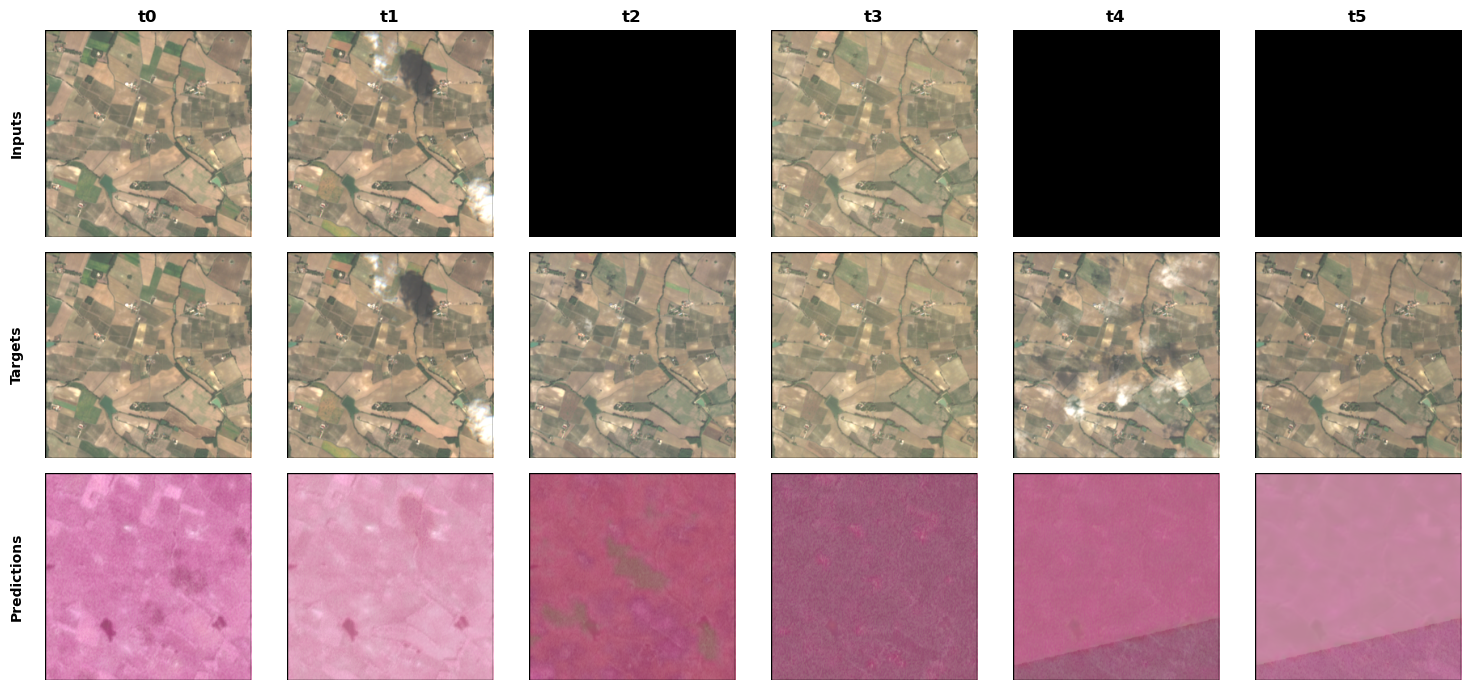

In [16]:
import matplotlib. pyplot as plt
import numpy as np
import matplotlib. patches as patches

# batch = next(iter(test_loader))
BRIGHTNESS_FACTOR = 3
t_sampled = [0, 2, 6, 8, 9, 10]
# t_sampled = [0, 1, 2, 3, 4, 5]
index = 156
sample = circa_ds.__getitem__(index)
batch = sample_to_batch(sample)

outputs = iterate_one_sample(batch, model, config, device=device)
inputs, targets, syn_masks, preds, prob_masks = outputs["inputs"], outputs["targets"], outputs["syn_masks"], outputs["preds"], outputs["prob_masks"]

# Prepare la donnée en re-normalisant et en changeant les dimensions 
t_start = 0
t_stop = 6 # targets.shape[1]
index_rgb = [2, 1, 0]
len_ts = t_stop - t_start

# targets_RGB = targets[0, t_start:t_stop, index_rgb, :, :].swapaxes(1, 3).swapaxes(1, 2) / 5_000
# preds_RGB = preds[0, t_start:t_stop, index_rgb, :, :].swapaxes(1, 3).swapaxes(1, 2) / 5_000

# Trim series according to input_t length
d = config.input_t // 2
data_S2 = inputs[0, d:-d, ...]
inputs_RVB = data_S2[:, index_rgb, ...].swapaxes(1, 3).swapaxes(1, 2) / 10_000
inputs_RVB = inputs_RVB[t_sampled, ...]

targets_sampled = targets[0, t_sampled, ...]
targets_RGB = targets_sampled[:, index_rgb, ...].swapaxes(1, 3).swapaxes(1, 2) / 10_000

preds_sampled = preds[0, t_sampled, :, :]
preds_RGB = preds_sampled[:, index_rgb, ...].swapaxes(1, 3).swapaxes(1, 2) / 10_000

images = torch.concatenate(
    [
        inputs_RVB,
        targets_RGB,
        preds_RGB,
    ],
    dim=0,
)

from model import visutils
images = visutils.apply_brightness_factor(images, factor=BRIGHTNESS_FACTOR)

# Créer la figure avec 4 lignes et 6 colonnes
nrows = int(images.shape[0] / len_ts)
fig, axes = plt.subplots(nrows=nrows, ncols=len_ts, figsize=(15, 7))

# Labels pour les colonnes (t0 à t5)
column_labels = [f't{i}' for i in range(len_ts)]

# Afficher les images
for idx, ax in enumerate(axes.flat):
    ax.imshow(images[idx])
    ax.axis('off')  # Masquer les axes
    
    rect = patches.Rectangle((0, 0), 1, 1, 
                               transform=ax.transAxes,
                               fill=False, 
                               edgecolor='black', 
                               linewidth=1)
    ax.add_patch(rect)
    
    if idx < len_ts:
        ax.set_title(column_labels[idx], fontsize=12, fontweight='bold')


plt.subplots_adjust(wspace=0.05, hspace=0.1)

row_labels = ['Inputs', 'Targets', 'Predictions']
for i, label in enumerate(row_labels):
    axes[i, 0].annotate(label, 
                        xy=(-0.1, 0.5),
                        xycoords='axes fraction',
                        fontsize=10, 
                        fontweight='bold',
                        ha='right',
                        va='center',
                        rotation=90)
 
plt.subplots_adjust(left=0.18)
plt.tight_layout()
plt.show()
# plt.savefig('ma_figure.png', dpi=300, bbox_inches='tight')

In [ ]:
x

# UnCRtainTS: métriques sur le tests sets avec masquages complets aléatoires

In [17]:
from model.visutils import display_metrics
from pathlib import Path

STORE = Path("/mnt/stores/store-dai")
folder_metrics = STORE / "tmp/speillet/metrics_UnCRtainTS"
assert folder_metrics.exists()

def open_metric(path_file):
    content = json.load(open(path_file))
    # Suppression des clés sur le MSE
    for x in ["mse", "mse_occluded_input_pixels", "mse_observed_input_pixels"]:
        content.pop(x)
    return content

metrics = {}
for training_type_folder in folder_metrics.iterdir():
    training_type = training_type_folder.name
    metrics[training_type] = {}
    path_metrics_file = training_type_folder / "test_metrics.json"
    metrics[training_type] = open_metric(path_metrics_file)

for training_type in metrics.keys():
    print(100 * "#")
    print("training_type", training_type)
    content = metrics[training_type]
    display_metrics(content)
    print(100 * "-")


####################################################################################################
training_type UnCRtainTS_bs_7_MGNLL_experiment


                   Cloud Reconstruction Metrics                    
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃      Metric ┃    Overall    ┃ Occluded Pixels ┃ Observed Pixels ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│         MAE │   2720.6375   │    2577.7424    │    2726.8276    │
│  MAE_BAND_0 │   2712.1096   │    2608.5271    │    2716.9475    │
│  MAE_BAND_1 │   3135.0308   │    3019.0615    │    3141.3347    │
│  MAE_BAND_2 │   1453.3561   │    1367.6031    │    1455.5211    │
│  MAE_BAND_3 │   2378.6333   │    2244.3247    │    2386.2742    │
│  MAE_BAND_4 │   2942.6968   │    2777.2141    │    2947.0183    │
│  MAE_BAND_5 │   3180.7207   │    3018.4573    │    3183.6816    │
│  MAE_BAND_6 │   1849.1427   │    1712.3055    │    1851.0341    │
│  MAE_BAND_7 │   2097.5039   │    1960.4456    │    2098.4373    │
│  MAE_BAND_8 │   4468.6724   │    4254.4321    │    4484.9961    │
│  MAE_BAND_9 │   2988.4778   │    2815.0840    │    3003.0300    │
│  MSE_BAND_0 │ 8193655.0000  │  7854208.5000   │  8204441.5000   │
│  MSE_BAND_1 │ 10782996.0000 │  10290466.0000  │  10808102.0000  │
│  MSE_BAND_2 │ 2651377.5000  │  2529605.5000   │  2632238.5000   │
│  MSE_BAND_3 │ 6297145.0000  │  5807531.0000   │  6319146.0000   │
│  MSE_BAND_4 │ 9630148.0000  │  8676907.0000   │  9653426.0000   │
│  MSE_BAND_5 │ 11378791.0000 │  10293468.0000  │  11403355.0000  │
│  MSE_BAND_6 │ 4702084.5000  │  3998776.5000   │  4711152.0000   │
│  MSE_BAND_7 │ 5710690.5000  │  4983887.0000   │  5721303.0000   │
│  MSE_BAND_8 │ 20865340.0000 │  19096990.0000  │  21002150.0000  │
│  MSE_BAND_9 │ 10100739.0000 │  9299260.0000   │  10170350.0000  │
│        PSNR │    10.4918    │     11.0234     │     10.4798     │
│ PSNR_BAND_0 │    11.2515    │     11.8453     │     11.2423     │
│ PSNR_BAND_1 │    10.0085    │     10.5462     │     9.9953      │
│ PSNR_BAND_2 │    16.0470    │     16.8007     │     16.0604     │
│ PSNR_BAND_3 │    12.1778    │     12.8561     │     12.1620     │
│ PSNR_BAND_4 │    10.3395    │     10.9821     │     10.3408     │
│ PSNR_BAND_5 │    9.6034     │     10.1986     │     9.6083      │
│ PSNR_BAND_6 │    13.7577    │     14.5352     │     13.7749     │
│ PSNR_BAND_7 │    12.7904    │     13.5617     │     12.8069     │
│ PSNR_BAND_8 │    6.8462     │     7.3265      │     6.8206      │
│ PSNR_BAND_9 │    10.0327    │     10.6796     │     10.0040     │
│          R2 │    0.2631     │     0.2914      │     0.2649      │
│   R2_BAND_0 │    0.0838     │     0.0861      │     0.0859      │
│   R2_BAND_1 │    0.1105     │     0.1035      │     0.1145      │
│   R2_BAND_2 │    0.0274     │     0.0547      │     0.0278      │
│   R2_BAND_3 │    0.1303     │     0.1316      │     0.1348      │
│   R2_BAND_4 │    0.1161     │     0.1182      │     0.1215      │
│   R2_BAND_5 │    0.1564     │     0.1662      │     0.1638      │
│   R2_BAND_6 │    0.0588     │     0.0743      │     0.0613      │
│   R2_BAND_7 │    0.1166     │     0.1247      │     0.1221      │
│   R2_BAND_8 │    0.1368     │     0.1510      │     0.1386      │
│   R2_BAND_9 │    0.0724     │     0.0987      │     0.0726      │
│        RMSE │   2996.5759   │    2848.1892    │    3001.2161    │
│ RMSE_BAND_0 │   2812.7468   │    2708.1858    │    2815.0874    │
│ RMSE_BAND_1 │   3234.6936   │    3116.6262    │    3239.0034    │
│ RMSE_BAND_2 │   1605.7009   │    1522.7220    │    1601.7053    │
│ RMSE_BAND_3 │   2487.1018   │    2351.4470    │    2491.5632    │
│ RMSE_BAND_4 │   3070.8640   │    2891.6287    │    3072.3103    │
│ RMSE_BAND_5 │   3340.3291   │    3155.8108    │    3341.0359    │
│ RMSE_BAND_6 │   2104.6077   │    1939.7340    │    2103.0828    │
│ RMSE_BAND_7 │   2338.6975   │    2169.8618    │    2337.2510    │
│ RMSE_BAND_8 │   4557.1235   │    4338.6104    │    4571.2915    │
│ RMSE_BAND_9 │   3164.5940   │    2994.3911    │    3175.2979    │
│         SAM │    0.2777     │     0.2793      │     0.

----------------------------------------------------------------------------------------------------
####################################################################################################
training_type UnCRtainTS_bs_4_lents_11_MGNLL_experiment_random_repaired


                   Cloud Reconstruction Metrics                    
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃      Metric ┃    Overall    ┃ Occluded Pixels ┃ Observed Pixels ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│         MAE │   2238.9495   │    2076.5867    │    2247.0110    │
│  MAE_BAND_0 │   975.1470    │    919.2852     │    973.2007     │
│  MAE_BAND_1 │   1396.2445   │    1284.6057    │    1399.4318    │
│  MAE_BAND_2 │   2530.4773   │    2382.2485    │    2541.9292    │
│  MAE_BAND_3 │   2744.4338   │    2562.2849    │    2756.6140    │
│  MAE_BAND_4 │   1133.2327   │    1049.2242    │    1131.4750    │
│  MAE_BAND_5 │   1569.6926   │    1425.7313    │    1571.1975    │
│  MAE_BAND_6 │   1726.4572   │    1553.4756    │    1729.4860    │
│  MAE_BAND_7 │   1923.2843   │    1714.9482    │    1929.1448    │
│  MAE_BAND_8 │   4280.1538   │    3995.8123    │    4304.9224    │
│  MAE_BAND_9 │   4110.3950   │    3878.2576    │    4132.6987    │
│  MSE_BAND_0 │ 1232618.6250  │  1293190.0000   │  1193717.2500   │
│  MSE_BAND_1 │ 2353276.0000  │  2174440.2500   │  2337730.2500   │
│  MSE_BAND_2 │ 7500588.0000  │  6944012.5000   │  7538697.5000   │
│  MSE_BAND_3 │ 8391645.0000  │  7388178.5000   │  8445652.0000   │
│  MSE_BAND_4 │ 2200782.7500  │  1751799.5000   │  2194969.7500   │
│  MSE_BAND_5 │ 4043232.0000  │  3088776.0000   │  4060130.2500   │
│  MSE_BAND_6 │ 4963592.5000  │  3655575.2500   │  4997002.0000   │
│  MSE_BAND_7 │ 6385013.5000  │  4400083.0000   │  6456843.0000   │
│  MSE_BAND_8 │ 21120256.0000 │  18047986.0000  │  21346746.0000  │
│  MSE_BAND_9 │ 19247446.0000 │  17132716.0000  │  19423664.0000  │
│        PSNR │    11.5146    │     11.9872     │     11.4994     │
│ PSNR_BAND_0 │    19.4846    │     20.3135     │     19.5490     │
│ PSNR_BAND_1 │    16.5581    │     17.5575     │     16.5715     │
│ PSNR_BAND_2 │    11.3888    │     12.0768     │     11.3688     │
│ PSNR_BAND_3 │    10.9186    │     11.5219     │     10.8991     │
│ PSNR_BAND_4 │    17.9563    │     18.5934     │     18.0303     │
│ PSNR_BAND_5 │    15.2550    │     15.9493     │     15.2975     │
│ PSNR_BAND_6 │    14.5845    │     15.2812     │     14.6200     │
│ PSNR_BAND_7 │    13.9314    │     14.6222     │     13.9534     │
│ PSNR_BAND_8 │    7.2137     │     7.7553      │     7.1777      │
│ PSNR_BAND_9 │    7.4127     │     7.9199      │     7.3794      │
│          R2 │    0.1072     │     0.1535      │     0.1068      │
│   R2_BAND_0 │    0.0437     │     0.0799      │     0.0440      │
│   R2_BAND_1 │    0.0521     │     0.0801      │     0.0543      │
│   R2_BAND_2 │    0.0349     │     0.0768      │     0.0357      │
│   R2_BAND_3 │    0.0410     │     0.0731      │     0.0433      │
│   R2_BAND_4 │    0.0861     │     0.1172      │     0.0944      │
│   R2_BAND_5 │    0.0201     │     0.0601      │     0.0234      │
│   R2_BAND_6 │    0.0225     │     0.0588      │     0.0251      │
│   R2_BAND_7 │    0.0315     │     0.0632      │     0.0330      │
│   R2_BAND_8 │    0.0252     │     0.0578      │     0.0264      │
│   R2_BAND_9 │    0.0258     │     0.0588      │     0.0267      │
│        RMSE │   2711.5530   │    2539.9570    │    2718.3289    │
│ RMSE_BAND_0 │   1087.8618   │    1045.3842    │    1076.4642    │
│ RMSE_BAND_1 │   1512.7429   │    1406.3188    │    1509.2252    │
│ RMSE_BAND_2 │   2718.4048   │    2570.6958    │    2725.0266    │
│ RMSE_BAND_3 │   2869.4905   │    2688.0859    │    2877.1897    │
│ RMSE_BAND_4 │   1354.7338   │    1243.0294    │    1347.1298    │
│ RMSE_BAND_5 │   1842.9131   │    1670.8348    │    1839.0585    │
│ RMSE_BAND_6 │   2011.4905   │    1810.1277    │    2009.2509    │
│ RMSE_BAND_7 │   2214.0151   │    1968.3699    │    2215.8025    │
│ RMSE_BAND_8 │   4463.2568   │    4170.7886    │    4484.0151    │
│ RMSE_BAND_9 │   4318.7280   │    4081.3672    │    4336.6831    │
│         SAM │    0.3375     │     0.3368      │     0.

----------------------------------------------------------------------------------------------------
####################################################################################################
training_type UnCRtainTS_bs_5_lents_7_MGNLL_experiment


                   Cloud Reconstruction Metrics                    
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃      Metric ┃    Overall    ┃ Occluded Pixels ┃ Observed Pixels ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│         MAE │   1740.9744   │    1652.8269    │    1745.6671    │
│  MAE_BAND_0 │   870.4785    │    861.1234     │    866.7339     │
│  MAE_BAND_1 │   1111.4565   │    1080.4982    │    1110.5725    │
│  MAE_BAND_2 │   1981.6315   │    1911.0151    │    1987.0151    │
│  MAE_BAND_3 │   1862.8868   │    1766.8733    │    1868.7504    │
│  MAE_BAND_4 │   842.9638    │    817.7667     │    839.7718     │
│  MAE_BAND_5 │   1120.8599   │    1066.2112    │    1120.7937    │
│  MAE_BAND_6 │   1176.4221   │    1110.9309    │    1177.2710    │
│  MAE_BAND_7 │   1273.4019   │    1172.5662    │    1277.1132    │
│  MAE_BAND_8 │   3709.1902   │    3456.2317    │    3730.9734    │
│  MAE_BAND_9 │   3460.4346   │    3285.0500    │    3477.6797    │
│  MSE_BAND_0 │ 1151470.5000  │  1272975.5000   │  1113452.0000   │
│  MSE_BAND_1 │ 1756104.1250  │  1798086.5000   │  1732061.5000   │
│  MSE_BAND_2 │ 5488969.5000  │  5296153.5000   │  5500552.0000   │
│  MSE_BAND_3 │ 4362566.0000  │  4132998.7500   │  4369318.5000   │
│  MSE_BAND_4 │ 1176332.1250  │  1145768.6250   │  1150914.0000   │
│  MSE_BAND_5 │ 2020340.1250  │  1830355.7500   │  2007691.6250   │
│  MSE_BAND_6 │ 2226879.2500  │  1984764.7500   │  2216862.7500   │
│  MSE_BAND_7 │ 2617138.2500  │  2152927.7500   │  2625098.2500   │
│  MSE_BAND_8 │ 15920175.0000 │  14053082.0000  │  16077283.0000  │
│  MSE_BAND_9 │ 14146810.0000 │  13188328.0000  │  14248482.0000  │
│        PSNR │    13.0401    │     13.5318     │     13.0315     │
│ PSNR_BAND_0 │    19.7957    │     20.1970     │     19.8733     │
│ PSNR_BAND_1 │    17.9049    │     18.4218     │     17.9456     │
│ PSNR_BAND_2 │    12.9925    │     13.6047     │     12.9913     │
│ PSNR_BAND_3 │    13.7843    │     14.5044     │     13.7804     │
│ PSNR_BAND_4 │    20.1280    │     20.4854     │     20.2113     │
│ PSNR_BAND_5 │    17.6373    │     18.0669     │     17.6770     │
│ PSNR_BAND_6 │    17.2511    │     17.6920     │     17.2872     │
│ PSNR_BAND_7 │    16.6439    │     17.2529     │     16.6560     │
│ PSNR_BAND_8 │    8.1935     │     8.8928      │     8.1585      │
│ PSNR_BAND_9 │    8.5821     │     9.2076      │     8.5554      │
│          R2 │    0.0640     │     0.1023      │     0.0645      │
│   R2_BAND_0 │    0.0441     │     0.0740      │     0.0434      │
│   R2_BAND_1 │    0.0568     │     0.0749      │     0.0581      │
│   R2_BAND_2 │    0.0373     │     0.0755      │     0.0370      │
│   R2_BAND_3 │    0.0534     │     0.0764      │     0.0553      │
│   R2_BAND_4 │    0.1261     │     0.1339      │     0.1335      │
│   R2_BAND_5 │    0.0289     │     0.0584      │     0.0326      │
│   R2_BAND_6 │    0.0263     │     0.0535      │     0.0295      │
│   R2_BAND_7 │    0.0264     │     0.0646      │     0.0290      │
│   R2_BAND_8 │    0.0235     │     0.0528      │     0.0250      │
│   R2_BAND_9 │    0.0269     │     0.0591      │     0.0281      │
│        RMSE │   2241.6902   │    2135.0227    │    2244.7275    │
│ RMSE_BAND_0 │   1047.7476   │    1041.4379    │    1035.5101    │
│ RMSE_BAND_1 │   1299.9021   │    1268.1620    │    1292.7473    │
│ RMSE_BAND_2 │   2295.9875   │    2207.9377    │    2297.3103    │
│ RMSE_BAND_3 │   2067.9045   │    1965.5581    │    2069.2100    │
│ RMSE_BAND_4 │   1027.6055   │    996.5873     │    1017.2704    │
│ RMSE_BAND_5 │   1360.0361   │    1295.2400    │    1354.6255    │
│ RMSE_BAND_6 │   1424.7379   │    1350.8992    │    1419.9320    │
│ RMSE_BAND_7 │   1534.1216   │    1414.1989    │    1533.6853    │
│ RMSE_BAND_8 │   3939.1958   │    3673.3032    │    3956.7769    │
│ RMSE_BAND_9 │   3742.1440   │    3556.4111    │    3754.6519    │
│         SAM │    0.3890     │     0.3889      │     0.

----------------------------------------------------------------------------------------------------


In [19]:
main_metrics =  {k:v for k,v in metrics["UnCRtainTS_bs_5_lents_7_MGNLL_experiment"].items() if k[-2] != "_"}

In [20]:
display_metrics(main_metrics)

               Cloud Reconstruction Metrics               
┏━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Metric ┃  Overall  ┃ Occluded Pixels ┃ Observed Pixels ┃
┡━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│    MAE │ 1740.9744 │    1652.8269    │    1745.6671    │
│   PSNR │  13.0401  │     13.5318     │     13.0315     │
│     R2 │  0.0640   │     0.1023      │     0.0645      │
│   RMSE │ 2241.6902 │    2135.0227    │    2244.7275    │
│    SAM │  0.3890   │     0.3889      │     0.3896      │
│   SSIM │  0.1371   │     0.1438      │     0.1367      │
└────────┴───────────┴─────────────────┴─────────────────┘